# Master thesis - Datacentric aproach to time series forecasting 

Authors:
- Berling Gustav - gusbe498@student.liu.se
- Janzén Albin - albja295@student.liu.se

Import libraries, data and set global parameters

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
from matplotlib.patches import Rectangle
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(1234)
tf.keras.utils.set_random_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

#Plot colors
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']


C:\Users\albin\AppData\Local\Temp\ipykernel_8588\2365416793.py:20: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  og_df = pd.read_csv('data/Structured/all_data.csv')


Remove empty data and change order of columns

In [3]:
#Drop all empty columns
df = og_df.dropna(axis=1, how='all')
del og_df
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

#Fill missing values with the previous value
#df = df.fillna(method='ffill')
#Fill missing values with the next value
#df = df.fillna(method='bfill')
df = df.fillna(value=-1)
#df = df.fillna(df.mean())
#Remove collumns with only one value
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)

#Change index of target variable  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

#Set date for end of test data
test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]

#Remove dates from dataframe
dates = df.pop('Date')
years = [year.split("-")[0] for year in dates]

#Save number of features
n_original_features = df.shape[1]
print(n_original_features)




C:\Users\albin\AppData\Local\Temp\ipykernel_8588\4046918908.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, 'SE1', first_column)


495


In [4]:
# Fit PCA to identify which features contribute the most to variance
pca = PCA()
pca.fit(df)

n_used_features = 15

# Get explained variance ratios of each principal component
variance_ratios = pca.explained_variance_ratio_

# Sort features by their explained variance ratios and select the top 20
top_n_features_idx = variance_ratios.argsort()[::-1][:n_used_features]
top_n_features = df.columns[top_n_features_idx]

# Select only the top 20 features from the original data
data_top_n = df[top_n_features]
df = data_top_n
n_features = n_used_features
colorpicker = plt.cm.jet(np.linspace(0,1,n_features))

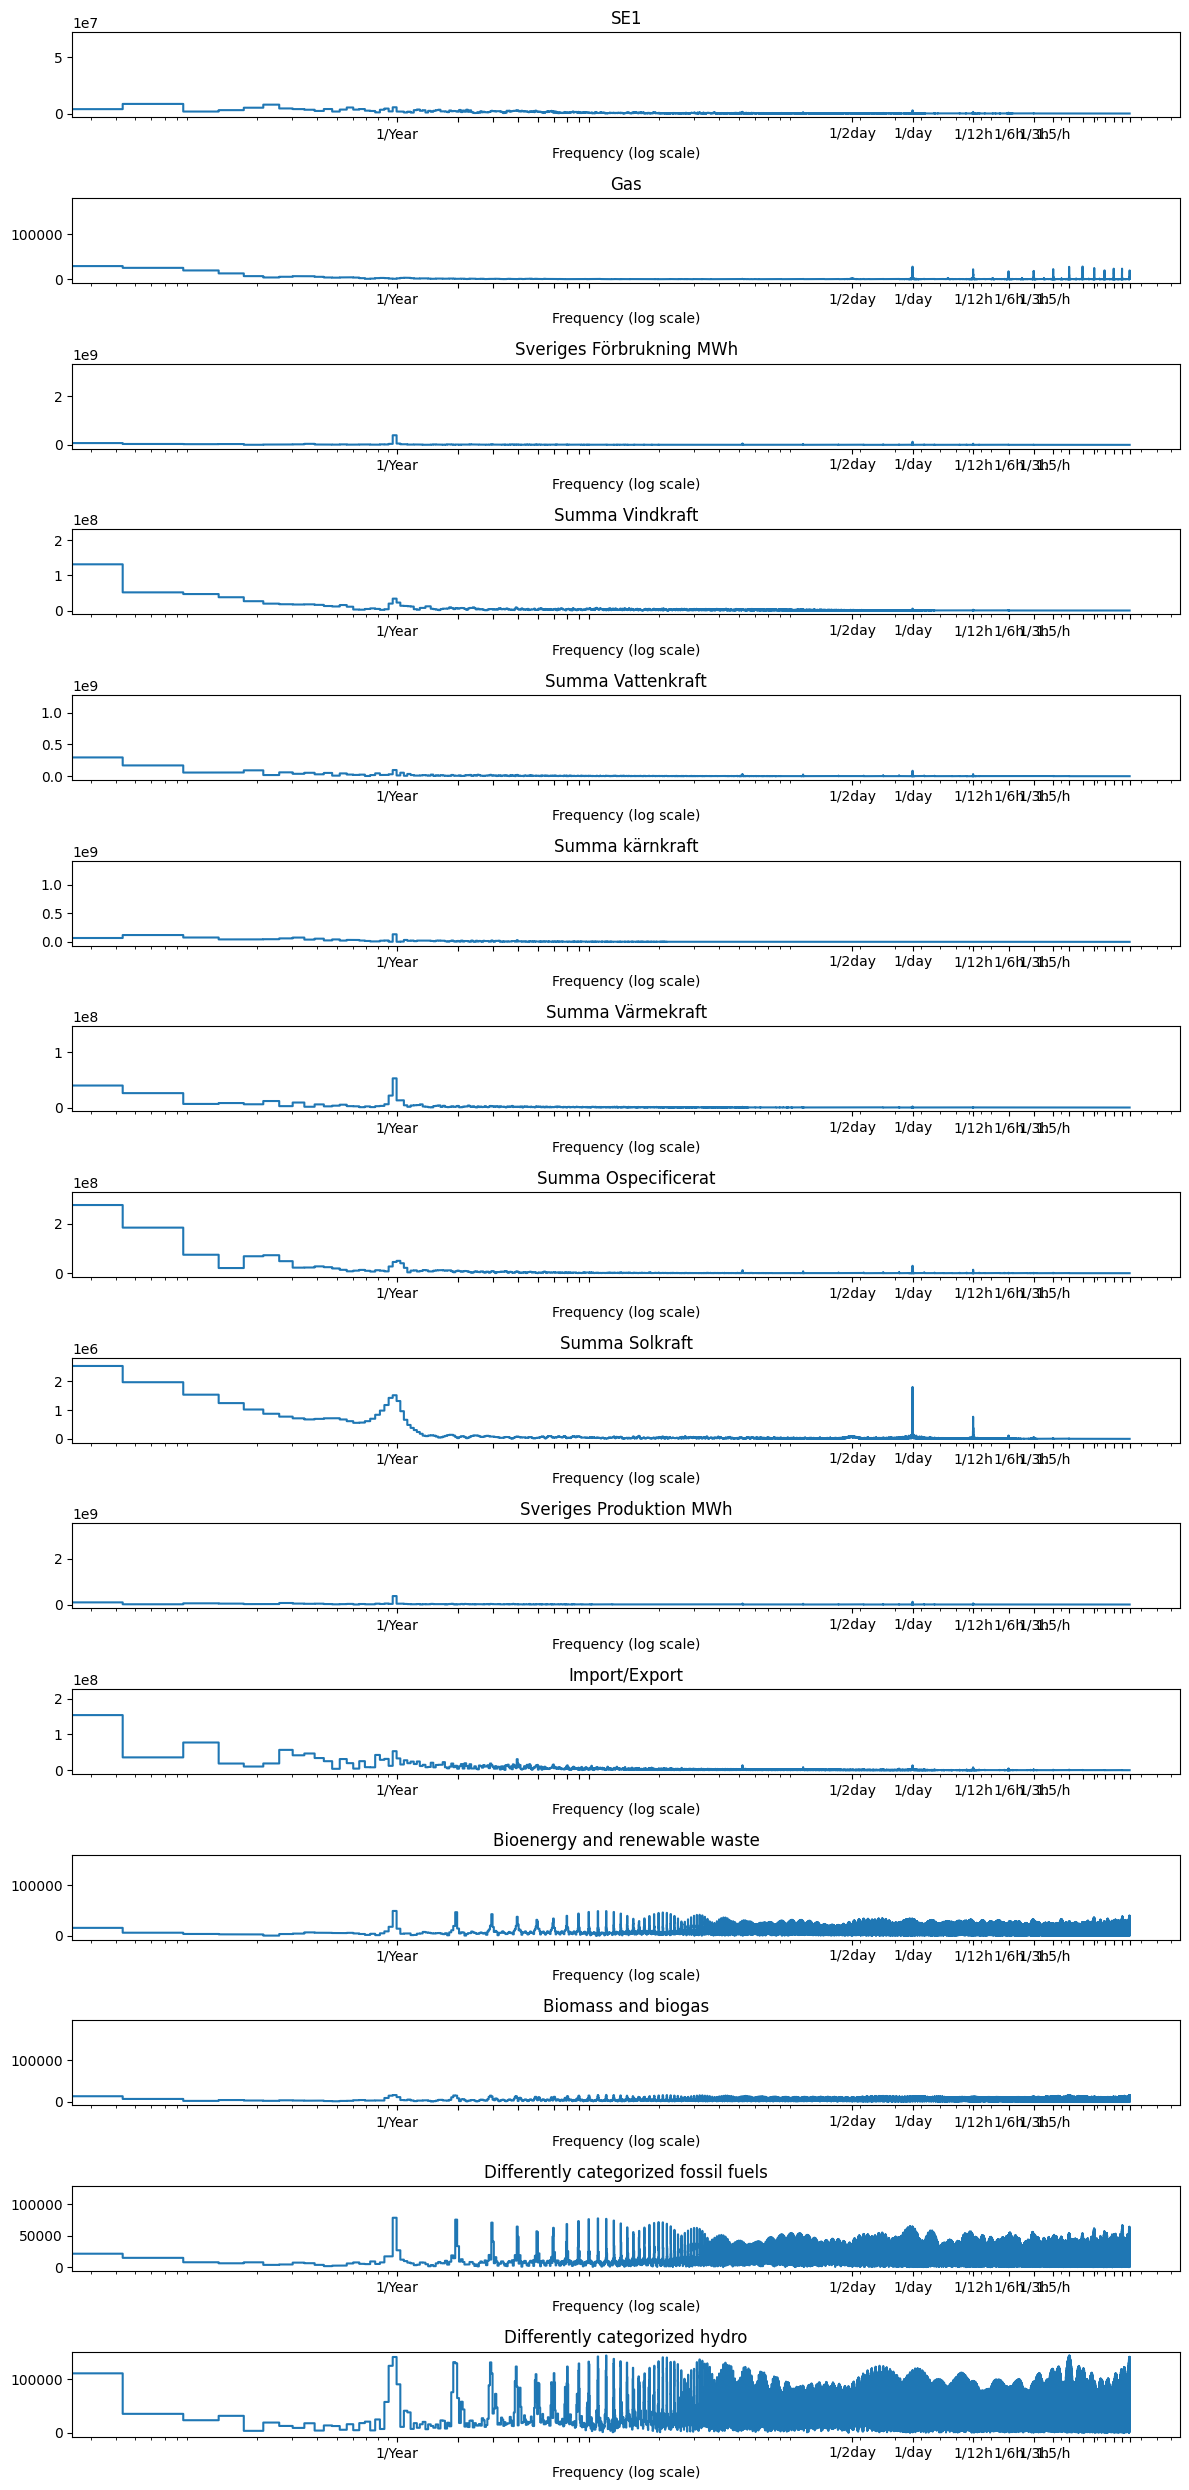

In [5]:
graphs_per_row = 1
fig, ax = plt.subplots(n_used_features, graphs_per_row, figsize=(12, 25))
for i in range(n_used_features):
    fft = tf.signal.rfft(df.iloc[:,i])
    f_per_dataset = np.arange(0, len(fft))
    n_samples_h = len(df['SE1']) 
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)
    f_per_year = f_per_dataset/years_per_dataset
    ax[i//graphs_per_row].set_title(df.columns[i])
    ax[i//graphs_per_row].step(f_per_year, np.abs(fft))
    ax[i//graphs_per_row].set_xscale('log')
    ax[i//graphs_per_row].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 365.2524/2, 365.2524, 365.2524*2, 365.2524*3, 365.2524*4, 365.2524*5, 365.2524*6, 365.2524*7, 365.2524*8, 365.2524*9, 365.2524*10, 365.2524*11, 365.2524*12], labels=['1/Year', '', '', '', '', '', '', '', '', '1/2day', '1/day', '1/12h', '1/6h', '1/3h', '1.5/h', '', '', '', '', '', '', ''])
    ax[i//graphs_per_row].set_xlabel('Frequency (log scale)')
plt.tight_layout()

In [6]:
date_time = pd.to_datetime(dates, format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
day_times_2 = day*2
day_div_2 = day/2
day_div_3 = day/3
day_div_4 = day/4
day_div_5 = day/5
day_div_6 = day/6
day_div_7 = day/7
day_div_8 = day/8
day_div_9 = day/9
day_div_10 = day/10
day_div_11 = day/11
day_div_12 = day/12
year = (365.2425)*day
year_div_2 = year/2
year_div_3 = year/3
year_div_4 = year/4
year_div_5 = year/5
year_div_6 = year/6
year_div_7 = year/7
year_div_8 = year/8
year_div_9 = year/9

df_many = df.copy()
df_few = df.copy()
df_sine = df.copy()

df_many['Day div 2 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_2))
df_few['Day div 2 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_2))
df_sine['Day div 2 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_2))

df_many['Day div 2 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_2))
df_few['Day div 2 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_2))

df_many['Day div 3 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_3))
df_few['Day div 3 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_3))
df_sine['Day div 3 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_3))

df_many['Day div 3 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_3))
df_few['Day div 3 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_3))

df_many['Day div 4 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_4))
df_few['Day div 4 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_4))
df_sine['Day div 4 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_4))

df_many['Day div 4 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_4))
df_few['Day div 4 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_4))

df_many['Day div 5 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_5))
df_sine['Day div 5 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_5))

df_many['Day div 5 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_5))

df_many['Day div 6 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_6))
df_sine['Day div 6 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_6))

df_many['Day div 6 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_6))

df_many['Day div 7 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_7))
df_sine['Day div 7 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_7))

df_many['Day div 7 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_7))

df_many['Day div 8 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_8))
df_sine['Day div 8 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_8))

df_many['Day div 8 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_8))

df_many['Day div 9 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_9))
df_sine['Day div 9 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_9))

df_many['Day div 9 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_9))

df_many['Day div 10 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_10))
df_sine['Day div 10 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_10))

df_many['Day div 10 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_10))

df_many['Day div 11 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_11))
df_sine['Day div 11 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_11))

df_many['Day div 11 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_11))

df_many['Day div 12 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_12))
df_sine['Day div 12 sin'] = np.sin(timestamp_s * (2 * np.pi / day_div_12))

df_many['Day div 12 cos'] = np.cos(timestamp_s * (2 * np.pi / day_div_12))

df_many['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_few['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_sine['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))

df_many['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_few['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

df_many['Day times 2 sin'] = np.sin(timestamp_s * (2 * np.pi / day_times_2))
df_few['Day times 2 sin'] = np.sin(timestamp_s * (2 * np.pi / day_times_2))
df_sine['Day times 2 sin'] = np.sin(timestamp_s * (2 * np.pi / day_times_2))

df_many['Day times 2 cos'] = np.cos(timestamp_s * (2 * np.pi / day_times_2))
df_few['Day times 2 cos'] = np.cos(timestamp_s * (2 * np.pi / day_times_2))

df_many['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_few['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_sine['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))

df_many['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df_few['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df_many['Year div 2 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_2))
df_few['Year div 2 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_2))
df_sine['Year div 2 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_2))

df_many['Year div 2 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_2))
df_few['Year div 2 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_2))

df_many['Year div 3 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_3))
df_few['Year div 3 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_3))
df_sine['Year div 3 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_3))

df_many['Year div 3 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_3))
df_few['Year div 3 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_3))

df_many['Year div 4 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_4))
df_few['Year div 4 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_4))
df_sine['Year div 4 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_4))

df_many['Year div 4 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_4))
df_few['Year div 4 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_4))

df_many['Year div 5 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_5))
df_sine['Year div 5 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_5))

df_many['Year div 5 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_5))

df_many['Year div 6 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_6))
df_sine['Year div 6 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_6))

df_many['Year div 6 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_6))

df_many['Year div 7 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_7))
df_sine['Year div 7 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_7))

df_many['Year div 7 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_7))

df_many['Year div 8 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_8))
df_sine['Year div 8 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_8))

df_many['Year div 8 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_8))

df_many['Year div 9 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_9))
df_sine['Year div 9 sin'] = np.sin(timestamp_s * (2 * np.pi / year_div_9))

df_many['Year div 9 cos'] = np.cos(timestamp_s * (2 * np.pi / year_div_9))

n_features = df.shape[1]
n_features_few = df_few.shape[1]
n_features_many = df_many.shape[1]
n_features_sine = df_sine.shape[1]


# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(df[df.columns])

scaler_few = MinMaxScaler()
scaler_few.fit_transform(df_few[df_few.columns])

scaler_many = MinMaxScaler()
scaler_many.fit_transform(df_many[df_many.columns])

scaler_sine = MinMaxScaler()
scaler_sine.fit_transform(df_sine[df_sine.columns])

#Applying spike cap for SE1 (target variable)
# Calculate the mean and standard deviation of Y
mean_y = np.mean(df['SE1'])
std_y = np.std(df['SE1'])

# Set the threshold to two standard deviations above the mean
threshold = mean_y + 3 * std_y

# Cap the values of Y that exceed the threshold
df.loc[df['SE1'] > threshold, 'SE1'] = threshold
df[df.columns] = scaler.transform(df[df.columns])

df_few.loc[df_few['SE1'] > threshold, 'SE1'] = threshold
df_few[df_few.columns] = scaler_few.transform(df_few[df_few.columns])

df_many.loc[df_many['SE1'] > threshold, 'SE1'] = threshold
df_many[df_many.columns] = scaler_many.transform(df_many[df_many.columns])

df_sine.loc[df_sine['SE1'] > threshold, 'SE1'] = threshold
df_sine[df_sine.columns] = scaler_sine.transform(df_sine[df_sine.columns])


<Axes: >

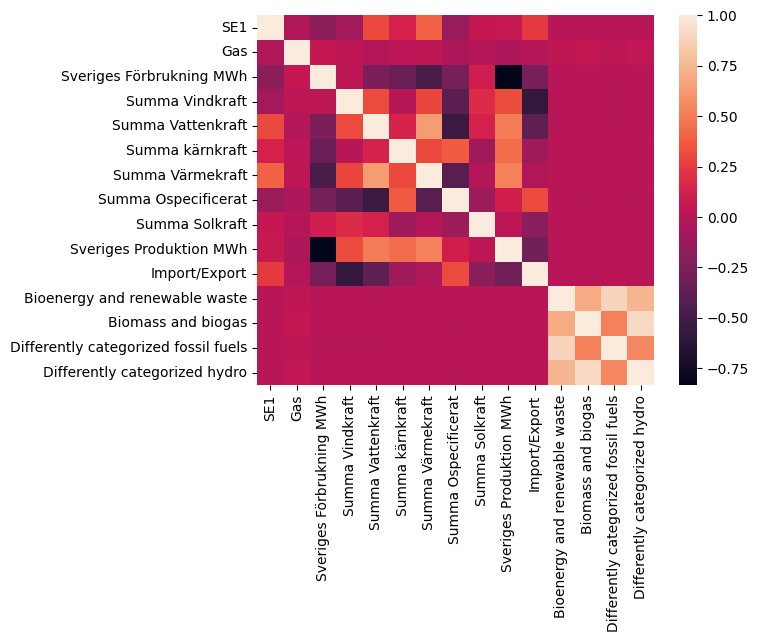

In [7]:
sns.heatmap(df.corr())

Plot target variable

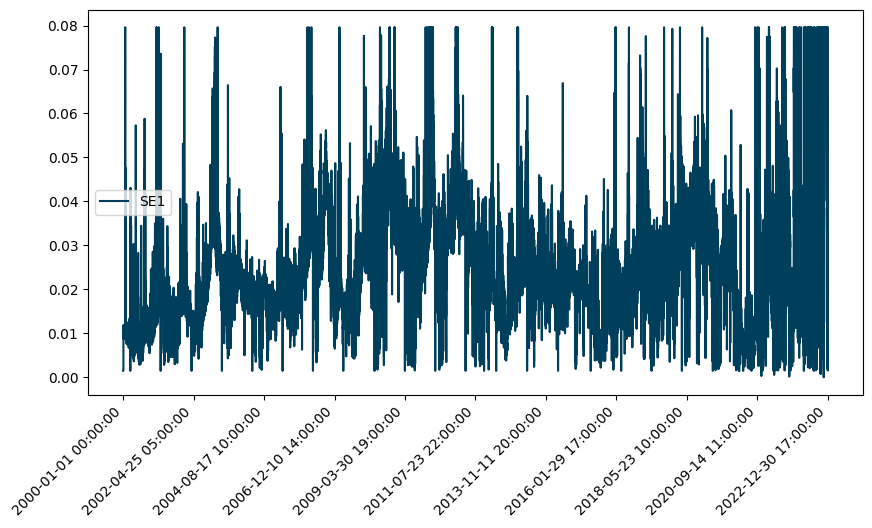

In [8]:
y = df['SE1']


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y, color=colors[0], label='SE1')
ax.legend()
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
plt.show()



Divide train, validation and test set

In [9]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
train_dates = dates[:val_end-val_size]

val_df = df[val_end-val_size:val_end]
val_dates = dates[val_end-val_size:val_end]

test_df = df[test_end-test_size:test_end]
test_dates = dates[test_end-test_size:test_end]

train_df = pd.concat([train_df, df[test_end:]])
train_dates = pd.concat([train_dates, dates[test_end:]])


train_df_many = df_many[:val_end-val_size]
val_df_many = df_many[val_end-val_size:val_end]
test_df_many = df_many[test_end-test_size:test_end]
train_df_many = pd.concat([train_df_many, df_many[test_end:]])

train_df_few = df_few[:val_end-val_size]
val_df_few = df_few[val_end-val_size:val_end]
test_df_few = df_few[test_end-test_size:test_end]
train_df_few = pd.concat([train_df_few, df_few[test_end:]])

train_df_sine = df_sine[:val_end-val_size]
val_df_sine = df_sine[val_end-val_size:val_end]
test_df_sine = df_sine[test_end-test_size:test_end]
train_df_sine = pd.concat([train_df_sine, df_sine[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 15)
(20287, 15)
(10143, 15)


Select target variable and lag the data for forecasting

In [10]:
def create_dataset(data, look_back=1):
    n_features = data.shape[1]
    dataX = np.empty((len(data)-look_back-1, look_back, n_features))
    dataY = np.empty((len(data)-look_back-1))
    for i in range(len(data)-look_back-1):
        dataX[i] = data[i:i+look_back]
        dataY[i] = data[i+look_back][0]
    return dataX, dataY

look_back = 12
X_train, y_train = create_dataset(train_df.values, look_back)
X_val, y_val = create_dataset(val_df.values, look_back)
X_test, y_test = create_dataset(test_df.values, look_back)

X_train_many, y_train_many = create_dataset(train_df_many.values, look_back)
X_val_many, y_val_many = create_dataset(val_df_many.values, look_back)
X_test_many, y_test_many = create_dataset(test_df_many.values, look_back)

X_train_few, y_train_few = create_dataset(train_df_few.values, look_back)
X_val_few, y_val_few = create_dataset(val_df_few.values, look_back)
X_test_few, y_test_few = create_dataset(test_df_few.values, look_back)

X_train_sine, y_train_sine = create_dataset(train_df_sine.values, look_back)
X_val_sine, y_val_sine = create_dataset(val_df_sine.values, look_back)
X_test_sine, y_test_sine = create_dataset(test_df_sine.values, look_back)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(172435, 12, 15)
(172435,)
(20274, 12, 15)
(20274,)
(10130, 12, 15)
(10130,)


Adapt the data to the batching

In [11]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
train_dates = train_dates[:num_samples_train]

X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
val_dates = val_dates[:num_samples_val]

X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
test_dates = test_dates[:num_samples_test]

X_train_many = X_train_many[:num_samples_train]
y_train_many = y_train_many[:num_samples_train]

X_val_many = X_val_many[:num_samples_val]
y_val_many = y_val_many[:num_samples_val]

X_test_many = X_test_many[:num_samples_test]
y_test_many = y_test_many[:num_samples_test]

X_train_few = X_train_few[:num_samples_train]
y_train_few = y_train_few[:num_samples_train]

X_val_few = X_val_few[:num_samples_val]
y_val_few = y_val_few[:num_samples_val]

X_test_few = X_test_few[:num_samples_test]
y_test_few = y_test_few[:num_samples_test]

X_train_sine = X_train_sine[:num_samples_train]
y_train_sine = y_train_sine[:num_samples_train]

X_val_sine = X_val_sine[:num_samples_val]
y_val_sine = y_val_sine[:num_samples_val]

X_test_sine = X_test_sine[:num_samples_test]
y_test_sine = y_test_sine[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172435, 12, 15)


Plot the data split (only target variable is shown but is done on the whole dataset)

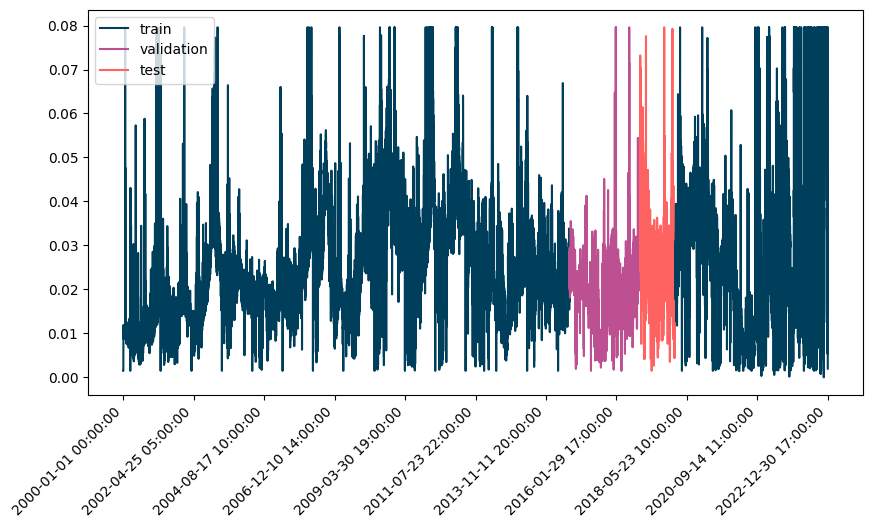

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color=colors[0], label='train')
ax.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color=colors[2], label='validation')
ax.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color=colors[3], label='test')
ax.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color=colors[0])
ax.set_xticks(np.arange(0, len(dates), len(dates)//10))
ax.set_xticklabels(dates[::len(dates)//10], rotation=45, ha='right')
ax.legend()
plt.show()

Create the LSTM model

In [13]:
# Define the model architecture
def create_model(n_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
        tf.keras.layers.Dense(1)
    ])
    return model

Class for plotting the learning process, used as a callback for the compile function of the model

In [14]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color=colors[0])
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color=colors[3])
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

Compile and fit the model: train the model

In [15]:
def compile_and_fit(model, X_train, y_train, X_val, y_val, patience=10):
  tf.keras.backend.clear_session()
  model.reset_states()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    restore_best_weights=True,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.build(X_train.shape)
  print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping,PlotLearning()])
  return history

# Baseline

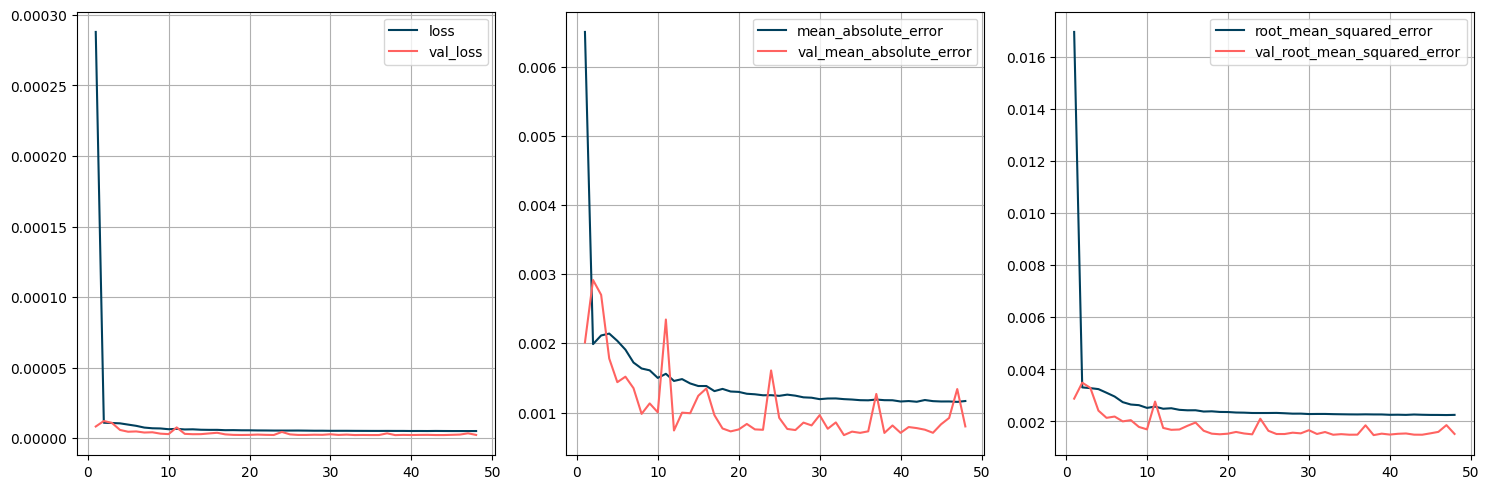

1347/1347 [==============================] - 19s 14ms/step - loss: 5.0773e-06 - mean_absolute_error: 0.0012 - root_mean_squared_error: 0.0023 - val_loss: 2.3134e-06 - val_mean_absolute_error: 7.9878e-04 - val_root_mean_squared_error: 0.0015


In [16]:
model_baseline = create_model(n_features)
history = compile_and_fit(model_baseline, X_train, y_train, X_val, y_val)

## Baseline result/residuals

In [17]:
result = model_baseline.predict(X_val, batch_size=batch_size)
# Get the index of the epoch with the lowest validation loss
best_epoch = np.argmin(history.history['val_loss'])

# Extract the RMSE and MAE values at the epoch with the lowest validation loss
best_rmse = history.history['val_root_mean_squared_error'][best_epoch]
best_mae = history.history['val_mean_absolute_error'][best_epoch]

# Print the RMSE and MAE values
print(f"RMSE at best epoch: {best_rmse}")
print(f"MAE at best epoch: {best_mae}")

158/158 [==============================] - 2s 7ms/step
RMSE at best epoch: 0.0014755582669749856
MAE at best epoch: 0.000704604375641793


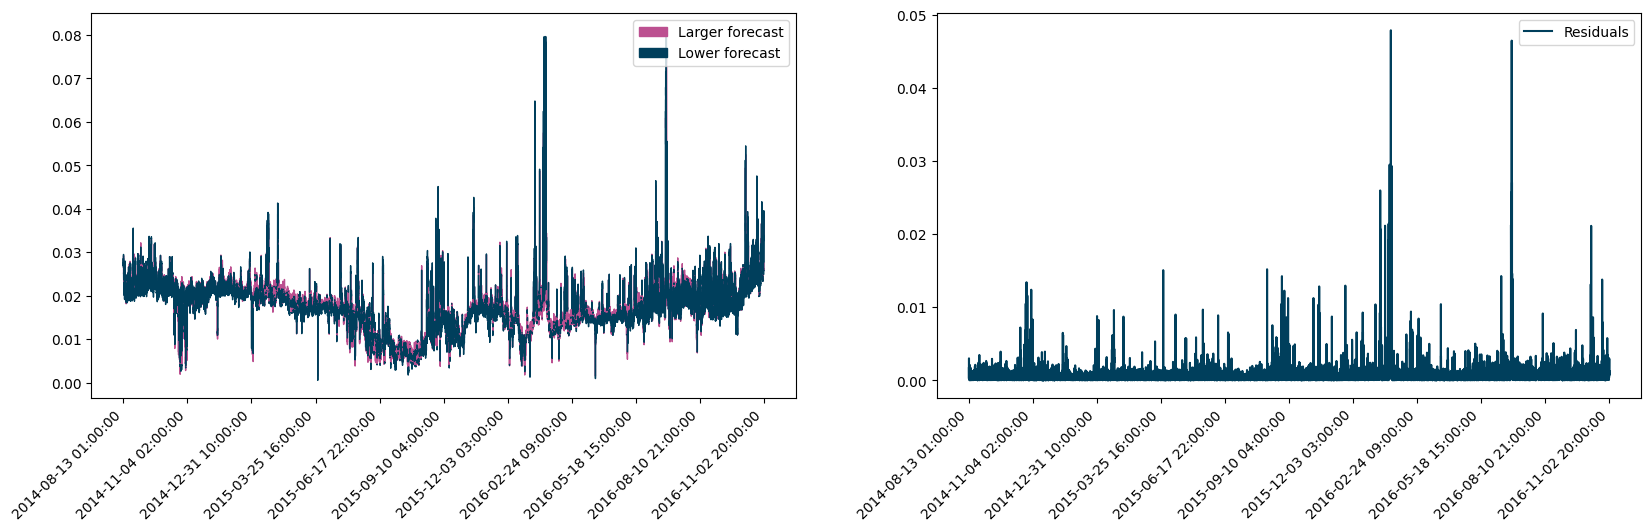

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
result = result.squeeze()
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result > y_val), 
    interpolate=True, color=colors[2], alpha=1, 
    label="Larger forecast"
)
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result < y_val), 
    interpolate=True, color=colors[0], alpha=1, 
    label="Lower forecast"
)
ax1.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax1.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
residuals = abs(np.subtract(np.array(result), np.array(y_val)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color=colors[0])
ax2.legend()
ax2.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax2.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
plt.show()

# Few frequencies

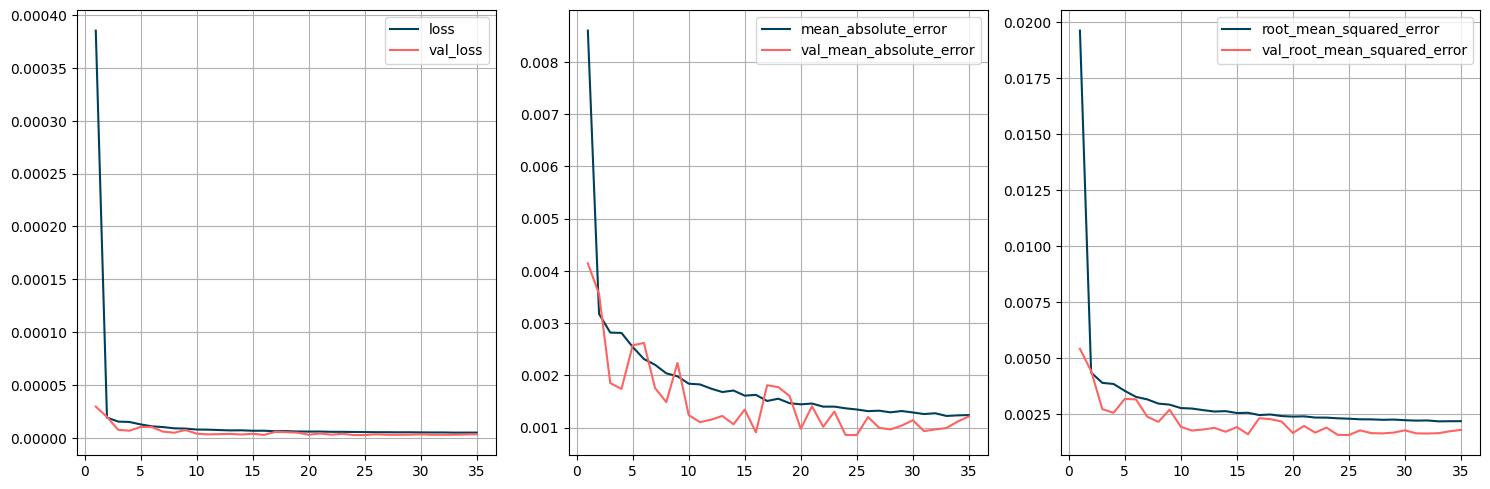

1347/1347 [==============================] - 20s 15ms/step - loss: 4.8019e-06 - mean_absolute_error: 0.0012 - root_mean_squared_error: 0.0022 - val_loss: 3.2540e-06 - val_mean_absolute_error: 0.0012 - val_root_mean_squared_error: 0.0018


In [19]:
model_few = create_model(n_features_few)
history_few = compile_and_fit(model_few, X_train_few, y_train, X_val_few, y_val)

In [20]:
result_few = model_few.predict(X_val_few, batch_size=batch_size)
# Get the index of the epoch with the lowest validation loss
best_epoch = np.argmin(history_few.history['val_loss'])

# Extract the RMSE and MAE values at the epoch with the lowest validation loss
best_rmse = history_few.history['val_root_mean_squared_error'][best_epoch]
best_mae = history_few.history['val_mean_absolute_error'][best_epoch]

# Print the RMSE and MAE values
print(f"RMSE at best epoch: {best_rmse}")
print(f"MAE at best epoch: {best_mae}")

158/158 [==============================] - 2s 7ms/step
RMSE at best epoch: 0.0015714114997535944
MAE at best epoch: 0.0008566949400119483


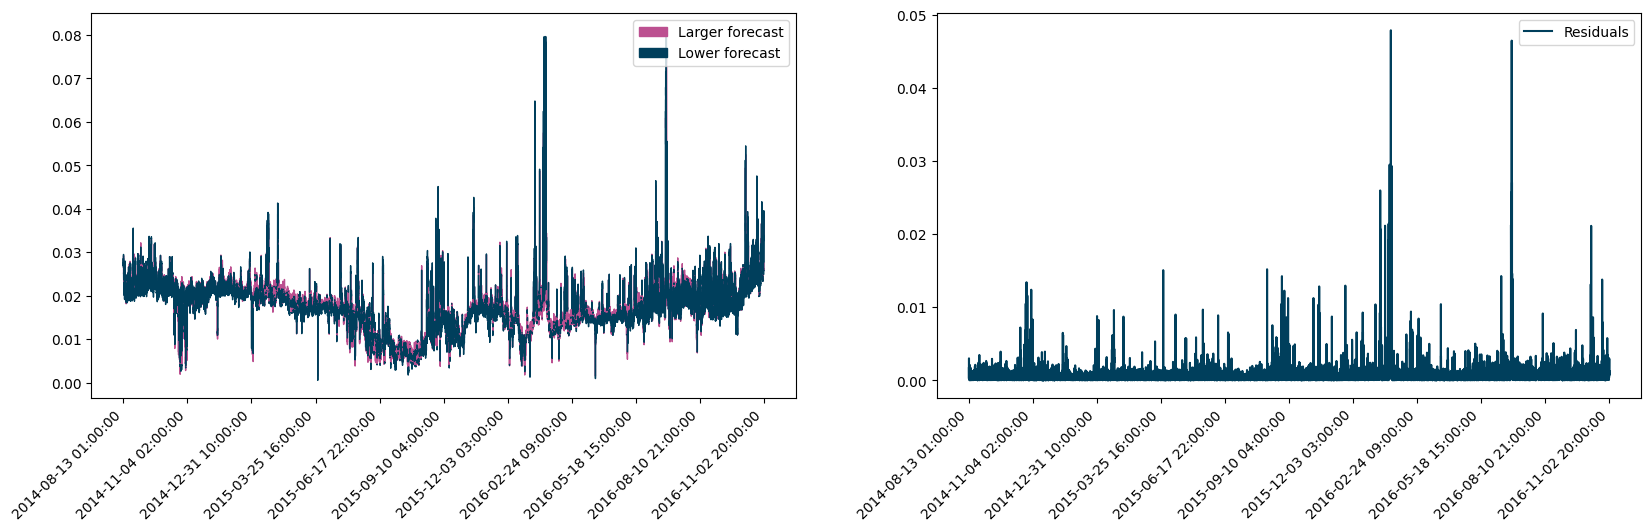

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
result = result.squeeze()
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result > y_val), 
    interpolate=True, color=colors[2], alpha=1, 
    label="Larger forecast"
)
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result < y_val), 
    interpolate=True, color=colors[0], alpha=1, 
    label="Lower forecast"
)
ax1.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax1.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
residuals = abs(np.subtract(np.array(result), np.array(y_val)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color=colors[0])
ax2.legend()
ax2.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax2.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
plt.show()

# Many frequencies

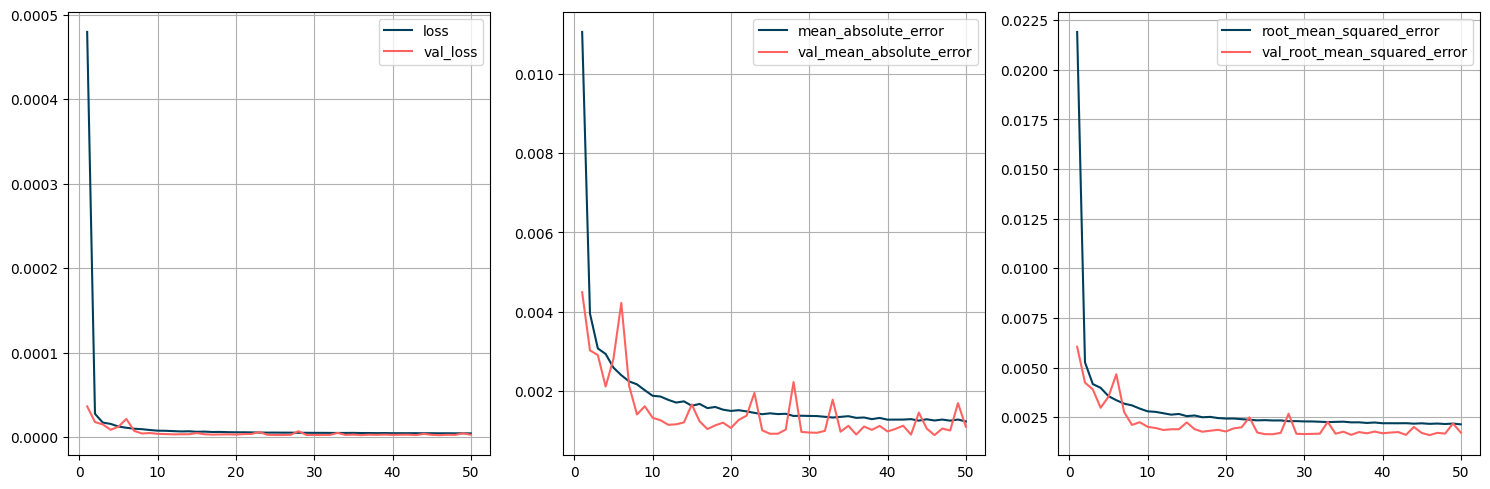

1347/1347 [==============================] - 25s 19ms/step - loss: 4.5935e-06 - mean_absolute_error: 0.0012 - root_mean_squared_error: 0.0021 - val_loss: 2.9822e-06 - val_mean_absolute_error: 0.0011 - val_root_mean_squared_error: 0.0017


In [22]:
model_many = create_model(n_features_many)
history_many = compile_and_fit(model_many, X_train_many, y_train, X_val_many, y_val)

In [23]:
result_many = model_many.predict(X_val_many, batch_size=batch_size)
# Get the index of the epoch with the lowest validation loss
best_epoch = np.argmin(history_many.history['val_loss'])

# Extract the RMSE and MAE values at the epoch with the lowest validation loss
best_rmse = history_many.history['val_root_mean_squared_error'][best_epoch]
best_mae = history_many.history['val_mean_absolute_error'][best_epoch]

# Print the RMSE and MAE values
print(f"RMSE at best epoch: {best_rmse}")
print(f"MAE at best epoch: {best_mae}")

158/158 [==============================] - 2s 10ms/step
RMSE at best epoch: 0.001600943855009973
MAE at best epoch: 0.0008905670256353915


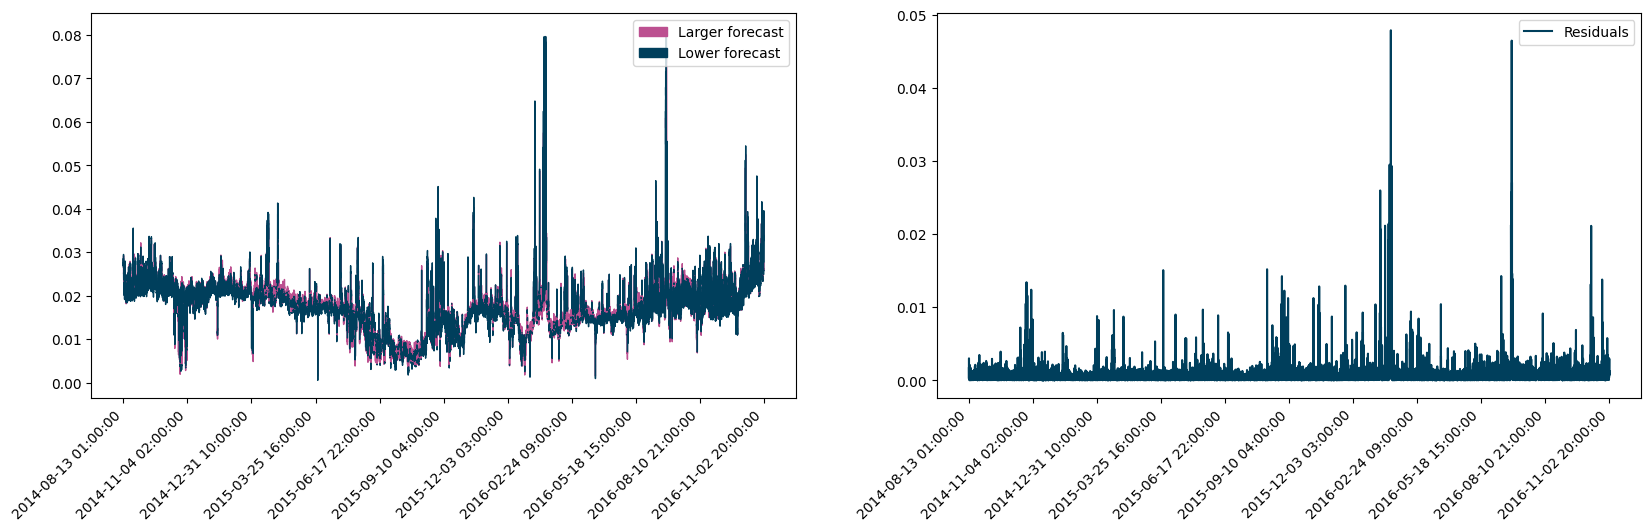

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
result = result.squeeze()
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result > y_val), 
    interpolate=True, color=colors[2], alpha=1, 
    label="Larger forecast"
)
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result < y_val), 
    interpolate=True, color=colors[0], alpha=1, 
    label="Lower forecast"
)
ax1.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax1.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
residuals = abs(np.subtract(np.array(result), np.array(y_val)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color=colors[0])
ax2.legend()
ax2.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax2.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
plt.show()

# Only sine

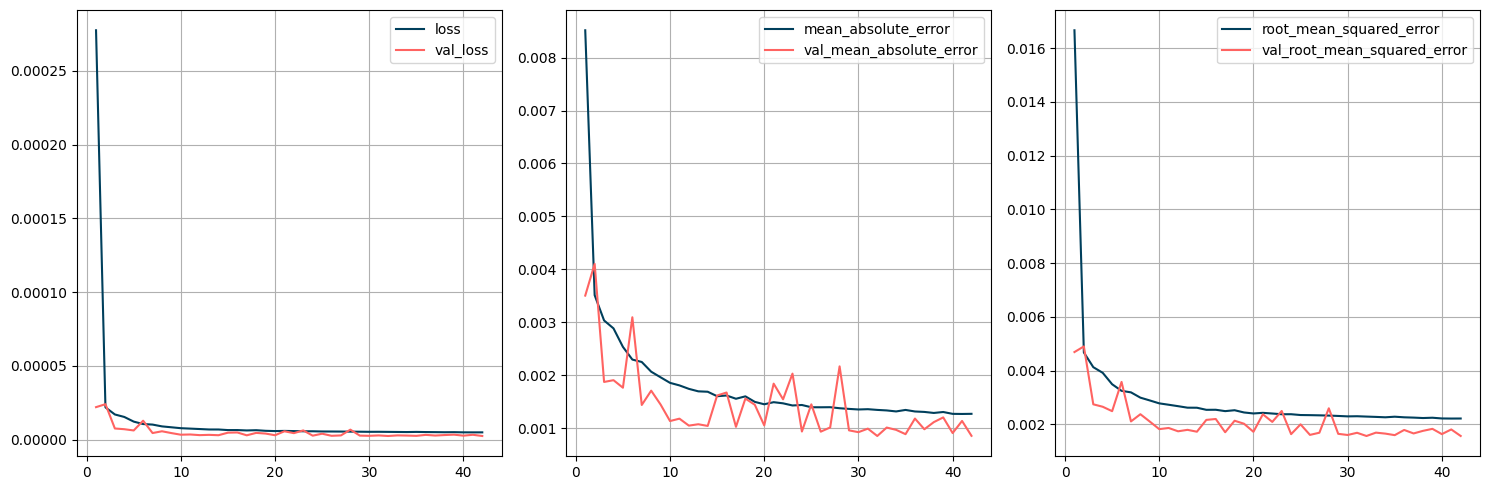

1347/1347 [==============================] - 29s 21ms/step - loss: 4.9372e-06 - mean_absolute_error: 0.0013 - root_mean_squared_error: 0.0022 - val_loss: 2.4727e-06 - val_mean_absolute_error: 8.5929e-04 - val_root_mean_squared_error: 0.0016


In [25]:
model_sine = create_model(n_features_sine)
history_sine = compile_and_fit(model_sine, X_train_sine, y_train, X_val_sine, y_val)

In [26]:
result_sine = model_sine.predict(X_val_sine, batch_size=batch_size)
# Get the index of the epoch with the lowest validation loss
best_epoch = np.argmin(history_sine.history['val_loss'])

# Extract the RMSE and MAE values at the epoch with the lowest validation loss
best_rmse = history_sine.history['val_root_mean_squared_error'][best_epoch]
best_mae = history_sine.history['val_mean_absolute_error'][best_epoch]

# Print the RMSE and MAE values
print(f"RMSE at best epoch: {best_rmse}")
print(f"MAE at best epoch: {best_mae}")

158/158 [==============================] - 2s 10ms/step
RMSE at best epoch: 0.0015718883369117975
MAE at best epoch: 0.0008559862617403269


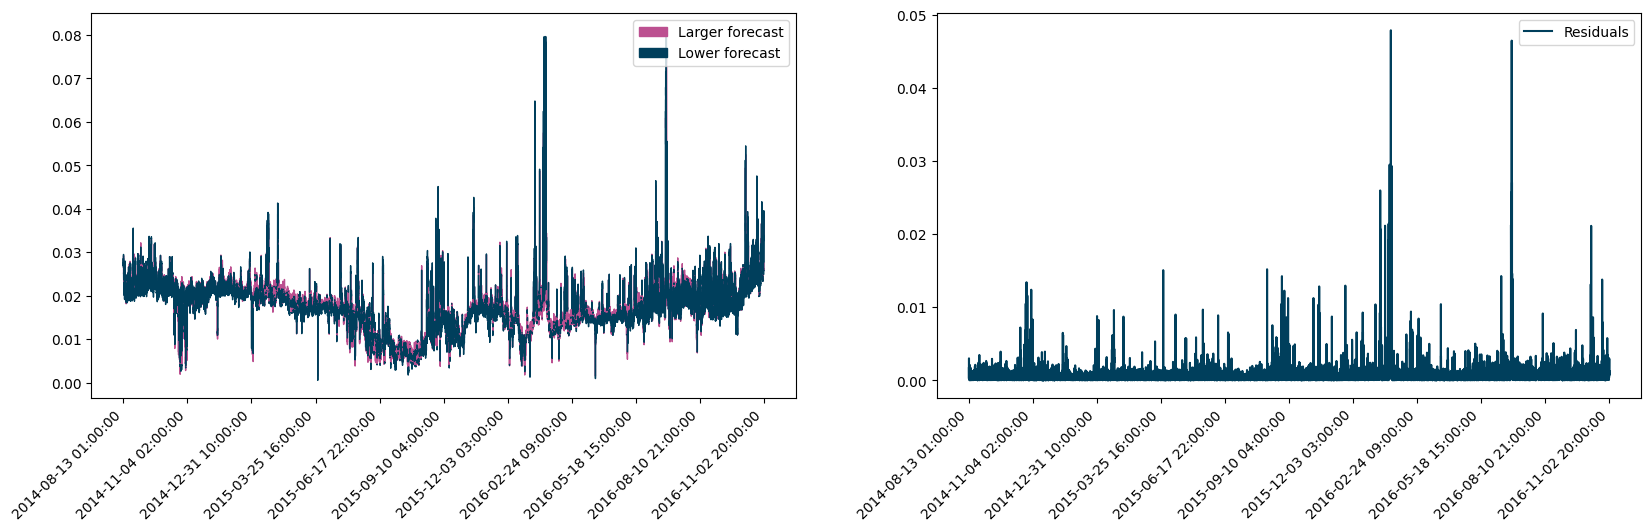

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
result = result.squeeze()
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result > y_val), 
    interpolate=True, color=colors[2], alpha=1, 
    label="Larger forecast"
)
ax1.fill_between(
    np.arange(0,len(result)), result, y_val, where=(result < y_val), 
    interpolate=True, color=colors[0], alpha=1, 
    label="Lower forecast"
)
ax1.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax1.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
residuals = abs(np.subtract(np.array(result), np.array(y_val)))
# residuals = y_test - result
ax1.legend()
ax2.plot(residuals, label='Residuals', color=colors[0])
ax2.legend()
ax2.set_xticks(np.arange(0, len(val_dates), len(val_dates)//10))
ax2.set_xticklabels(val_dates[::len(val_dates)//10], rotation=45, ha='right')
plt.show()